In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Preprocessing

## Parameters

In [3]:
# parameters

_round_num = 3
_symbol = "BANANAS"
# _day_ind = -2
# _day_range = [-1, 0, 1]
_day_range = [0, 1, 2]
_book_range = list(range(1, 3+1))
_max_time = 1000000
_time_step = 100

In [4]:
def get_file_trades(day):
    fname = f"../data/round{_round_num}/trades_round_{_round_num}_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

## read data

In [5]:
# get data for each day
trades = []
prices = []

for day in _day_range:
    # get data from files
    trade_df = get_file_trades(day)
    price_df = get_file_prices(day)
    
    trade_df["day"] = day
    
    trades += [trade_df]
    prices += [price_df]

# concat all data
trade_df = pd.concat(trades)
price_df = pd.concat(prices)

# rename columns
price_df = price_df.rename({"product": "symbol"}, axis=1)
price_df = price_df.rename({"timestamp": "time"}, axis=1)
trade_df = trade_df.rename({"timestamp": "time"}, axis=1)

# # filter for specific symbol
trade_df = trade_df[trade_df["symbol"] == _symbol]
price_df = price_df[price_df["symbol"] == _symbol]

# reset indexes
trade_df = trade_df.reset_index(drop=True)
price_df = price_df.reset_index(drop=True)


# print columns that we believe to be irrelevant
# currency - SEASHELLS only
# buyer - nan only
# seller - nan only
display(trade_df["currency"].value_counts())
display(trade_df["buyer"].value_counts())
display(trade_df["seller"].value_counts())

# drop irrelevant columns
trade_df = trade_df.drop(["currency", "buyer", "seller"], axis=1)

# calculate new time (for multiday)
trade_df["time"] = trade_df["time"] + (trade_df["day"] - min(_day_range)) * _max_time
price_df["time"] = price_df["time"] + (price_df["day"] - min(_day_range)) * _max_time

# rename "bid" to "buy"
# rename "ask" to "sell"
price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)


fname ../data/round3/trades_round_3_day_0_nn.csv
fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round3/trades_round_3_day_1_nn.csv
fname ../data/round3/prices_round_3_day_1.csv
fname ../data/round3/trades_round_3_day_2_nn.csv
fname ../data/round3/prices_round_3_day_2.csv


SEASHELLS    8459
Name: currency, dtype: int64

Series([], Name: buyer, dtype: int64)

Series([], Name: seller, dtype: int64)

In [6]:
# clean unreasonable data

if _symbol == "BANANAS":
    display(trade_df[trade_df["price"] < 4500])
    display(trade_df[trade_df["price"] > 5500])

    trade_df = trade_df[trade_df["price"] >= 4500]
    trade_df = trade_df[trade_df["price"] <= 5500]



Empty DataFrame
Columns: [time, symbol, price, quantity, day]
Index: []

Empty DataFrame
Columns: [time, symbol, price, quantity, day]
Index: []

# Large Quotes

## calculate large quote data

In [7]:
def get_book_large_size(side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df

In [8]:
# get big buy/sell quotes
buy_df = get_book_large_size("buy")
sell_df = get_book_large_size("sell")

# create big quote_df
quote_df = pd.merge(buy_df, sell_df, on="time")
quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

# edge is calculated from perspective of seller (it is the price )
trade_df = trade_df.merge(quote_df[["time", "mid_price"]], on="time")
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid_price"]

## whale quote spreads

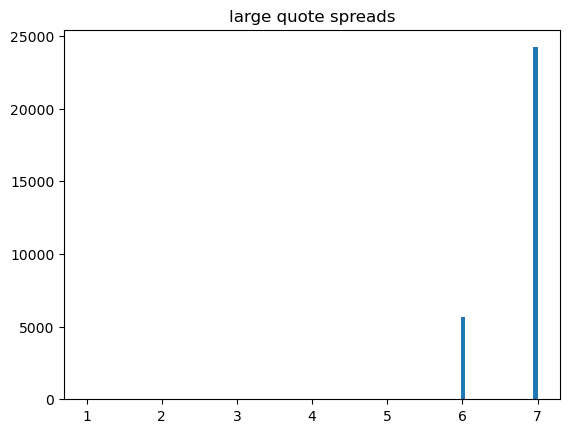

index  spread
0    7.0   24226
1    6.0    5685
2    5.0      29
3    1.0      20
4    3.0      16
5    2.0      15
6    4.0       9

In [9]:
plt.hist(quote_df["spread"], bins=100)
plt.title("large quote spreads")
plt.show()

display(quote_df["spread"].value_counts().reset_index())

## whale quote: order over time

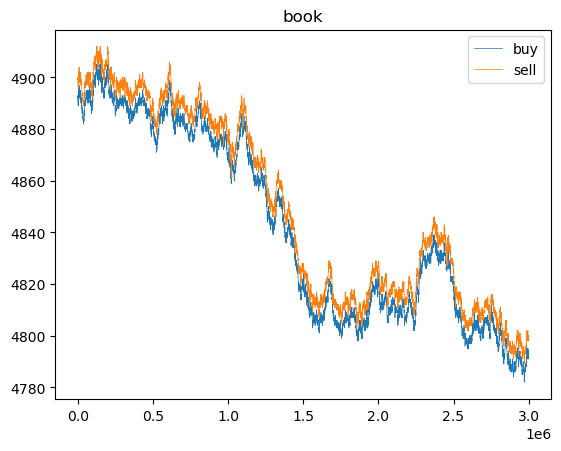

In [10]:
# lb, ub = 2e6, 2e6+1e5
# quote_df = quote_df[lb <= quote_df["time"]]
# quote_df = quote_df[quote_df["time"] <= ub]

plt.plot(quote_df["time"], quote_df["buy_price"], linewidth=0.5, label="buy")
plt.plot(quote_df["time"], quote_df["sell_price"], linewidth=0.5, label="sell")
plt.title("book")
plt.legend()

In [11]:
quote_df

buy_price  buy_size     time  sell_price  sell_size  mid_price  spread
0         4892.0      30.0        0      4899.0       30.0     4895.5     7.0
1         4892.0      31.0      100      4898.0       31.0     4895.0     6.0
2         4892.0      22.0      200      4899.0       22.0     4895.5     7.0
3         4893.0      25.0      300      4900.0       23.0     4896.5     7.0
4         4893.0      25.0      400      4899.0       25.0     4896.0     6.0
...          ...       ...      ...         ...        ...        ...     ...
29995     4791.0      28.0  2999500      4798.0       28.0     4794.5     7.0
29996     4792.0      30.0  2999600      4799.0       30.0     4795.5     7.0
29997     4792.0      28.0  2999700      4799.0       28.0     4795.5     7.0
29998     4792.0      29.0  2999800      4799.0       29.0     4795.5     7.0
29999     4792.0      25.0  2999900      4799.0       25.0     4795.5     7.0

[30000 rows x 7 columns]

## whale quote sizes

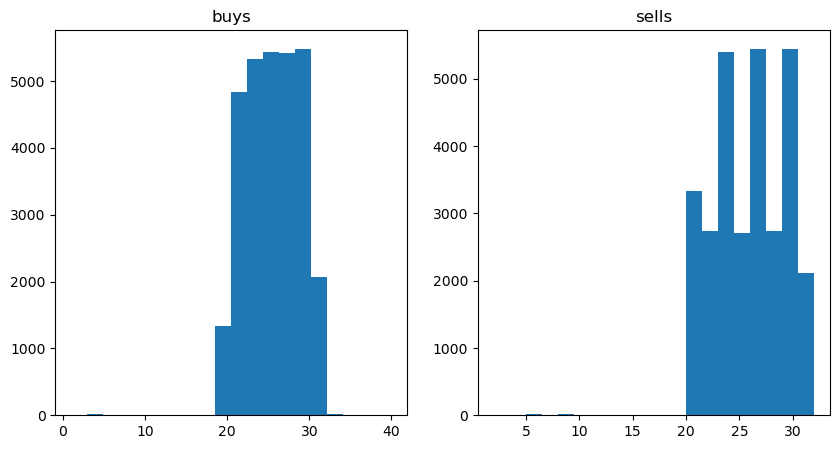

index  buy_size
0    22.0      2790
1    29.0      2773
2    25.0      2742
3    27.0      2717
4    30.0      2712
5    28.0      2706
6    26.0      2687
7    24.0      2685
8    23.0      2652
9    21.0      2042
10   31.0      1404
11   20.0      1304
12   32.0       660
13   19.0        35
14   33.0        14
15    3.0         9
16   34.0         8
17   36.0         7
18   38.0         6
19   10.0         6
20    5.0         6
21    4.0         4
22    6.0         4
23    7.0         4
24   12.0         3
25    1.0         3
26   16.0         2
27   35.0         2
28   11.0         2
29   13.0         2
30    8.0         1
31    2.0         1
32    9.0         1
33   40.0         1
34   18.0         1
35   37.0         1
36   17.0         1
37   39.0         1
38   15.0         1

index  sell_size
0    29.0       2767
1    27.0       2744
2    22.0       2742
3    28.0       2740
4    24.0       2725
5    25.0       2715
6    26.0       2704
7    23.0       2678
8    30.0       2677
9    21.0       2031
10   31.0       1405
11   20.0       1304
12   32.0        708
13    4.0         10
14    5.0          9
15    8.0          8
16    3.0          7
17    6.0          5
18    7.0          5
19    9.0          5
20   10.0          4
21   13.0          3
22    2.0          2
23   11.0          1
24   12.0          1

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(quote_df["buy_size"], bins=20)
plt.title("buys")

plt.subplot(122)
plt.hist(quote_df["sell_size"], bins=20)
plt.title("sells")

plt.show()


display(quote_df["buy_size"].value_counts().reset_index())
display(quote_df["sell_size"].value_counts().reset_index())

## whale quote movements

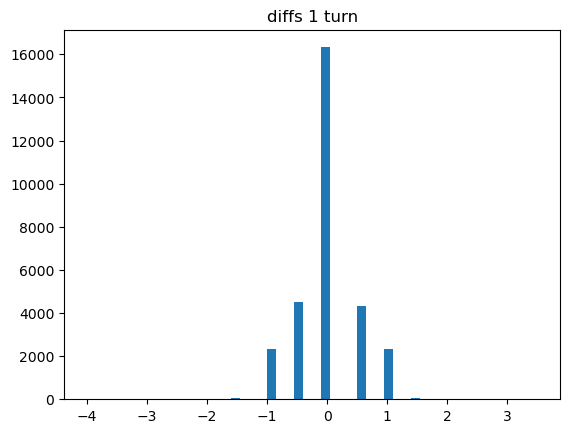

count      mean       std  min  25%  50%  75%  max
mid_price  29999.0 -0.003333  0.504056 -4.0  0.0  0.0  0.0  3.5

std size 87.30361234248696
total change -100.0
z-score -1.1454279761953705


In [13]:
# diffs
diffs = quote_df["mid_price"] - quote_df["mid_price"].shift(1)
diffs = diffs.dropna()

_ = plt.hist(diffs, bins=50)
plt.title("diffs 1 turn")
plt.show()


diff_desc = pd.DataFrame(diffs).describe().T
display(diff_desc)

stdev = np.sqrt(len(diffs))* diff_desc["std"].iloc[0]
print("std size", stdev)
print("total change", diffs.sum())
print("z-score", diffs.sum() / stdev)

# Postbook

## postbook helper methods

In [14]:
def get_postbook_bounds(time, interval):
    
    # get nearest 100k
    
    lb = (time // interval) * interval
    ub = lb + interval
        
    # filter data to only use interval
    ts = trade_df[(lb < trade_df["time"]) & (trade_df["time"] < ub)]
    ps = price_df[(lb < price_df["time"]) & (price_df["time"] < ub)]
    

    # calc min/max prices
    min_prices = []
    max_prices = []

    for i in _book_range:
        prices = ps[f"buy_price_{i}"]
        min_prices += [prices.min()]
        max_prices += [prices.max()]

    for i in _book_range:
        prices = ps[f"sell_price_{i}"]
        min_prices += [prices.min()]
        max_prices += [prices.max()]

    prices = ts["price"]
    min_prices += [prices.min()]
    max_prices += [prices.max()]


    xmin = min(min_prices)
    xmax = max(max_prices)
    
    
    
    # calc min/max sizes
    
    max_sizes = []
    
    # include 
    for i in _book_range:
        sizes = ps[f"buy_volume_{i}"]
        max_sizes += [sizes.max()]
        
    for i in _book_range:
        sizes = ps[f"sell_volume_{i}"]
        max_sizes += [sizes.max()]
    
    # include trade sizes
    max_sizes += [trade_df["quantity"].max()]
    
    ymin = 0
    ymax = max(max_sizes)
    
    return xmin, xmax, ymin, ymax

In [15]:
def get_book(sym, time):
    cur_prices = price_df[price_df["time"] == time].iloc[0]
    
    buys = []

    for i in _book_range:
        price, size = cur_prices[f"buy_price_{i}"], cur_prices[f"buy_volume_{i}"]
        if np.isnan(price):
            continue
        buys += [{"price": price, "quantity": size}]

    sells = []

    for i in _book_range:
        price, size = cur_prices[f"sell_price_{i}"], cur_prices[f"sell_volume_{i}"]
        if np.isnan(price):
            continue
        sells += [{"price": price, "quantity": size}]
        
    buys = pd.DataFrame(buys, columns=["price", "quantity"])
    sells = pd.DataFrame(sells, columns=["price", "quantity"])
    
    empty = pd.DataFrame([], columns=["price", "quantity"])

    return buys, sells, empty, empty


def get_trades(sym, time):
    
#     market_ts = trade_df[(trade_df["symbol"] == sym) & (trade_df["time"] == time)]
    market_ts = trade_df[trade_df["time"] == time]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
#     my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, pd.DataFrame([], columns=market_ts.columns)
    

def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    market_ts, my_ts = get_trades(sym, time + _time_step)

    
    # make bars have correct sign
#     sells["quantity"] *= -1
#     my_buys["quantity"] *= -1
#     my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    ref_ema = quote_df[quote_df["time"] == time]["mid_price"].iloc[0]
    plt.axvline(x=ref_ema, color="black", linestyle='dotted')
    
#     ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time}")
#     plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span}")
    plt.show()
    
    
    ### print raw info
#     print("ref_ema", ref_ema)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
def show_book_simple(
        sym,
        time=0,
        bound_interval=10000,
        # ymin=None,
        # ymax=None,
        ):
    
    xmin, xmax, ymin, ymax = get_postbook_bounds(time, bound_interval)
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=-10,
        ymax=ymax,
    )

## Postbook reconstruction

In [16]:

interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS", "PINA_COLADAS", "COCONUTS"],
    time=(0, len(_day_range) * _max_time, _time_step),
    bound_interval=10000,
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS', 'PINA_COLADAS', 'COCONUTS'), v…

<function __main__.show_book_simple(sym, time=0, bound_interval=10000)>

In [17]:
# filter between our times
# trade_df = trade_df[(2e6 <= trade_df["time"]) & (trade_df["time"] < 2e6 + 1e5)]
# price_df = price_df[(2e6 <= price_df["time"]) & (price_df["time"] < 2e6 + 1e5)]


## Best Taker Analysis

In [18]:
# get all buy_order_df
buy_data = [price_df[[f"buy_price_{i}", f"buy_volume_{i}", "time"]] for i in _book_range]
buy_data = [df.set_axis(labels=["price", "quantity", "time"], axis=1) for df in buy_data]
buy_df = pd.concat(buy_data).dropna()
buy_df = buy_df.sort_values(by="time").reset_index(drop=True)

# get all sell_order_df
sell_data = [price_df[[f"sell_price_{i}", f"sell_volume_{i}", "time"]] for i in _book_range]
sell_data = [df.set_axis(labels=["price", "quantity", "time"], axis=1) for df in sell_data]
sell_df = pd.concat(sell_data).dropna()
sell_df = sell_df.sort_values(by="time").reset_index(drop=True)

# negate quantity for sells
sell_df["quantity"] *= -1

In [19]:
# combine buy_df/sell_df into order_df
order_df = pd.concat([buy_df, sell_df]) \
                .sort_values(by=["time", "price"], ascending=True) \
                .reset_index(drop=True)

# merge mid_price (of large quotes) into order_df
order_df = order_df.merge(quote_df[["time", "mid_price"]], on="time")

# calculate edge if this order goes through
order_df["edge"] = np.sign(order_df["quantity"]) * (order_df["mid_price"] - order_df["price"])


In [20]:
# find orders with negative edge for maker (taker wins)
taker_df = order_df[order_df["edge"] <= 0].copy()

taker_df["edge"] = -1 * taker_df["edge"]

taker_df["abs_quantity"] = taker_df["quantity"].abs()
taker_df["pnl"] = taker_df["edge"] * taker_df["abs_quantity"]

# is buy from our perspective
taker_df["is_buy"] = taker_df["quantity"] < 0


In [21]:
# calculate total potential taker profit
print("take edge total", taker_df["pnl"].sum())

take edge total 21106.0


### edge distr of good takes

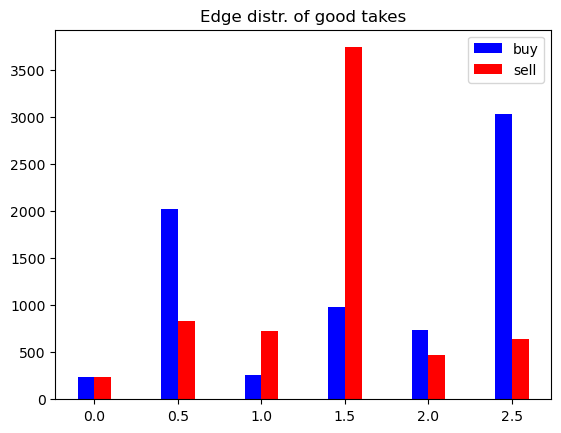

buy_quantity  sell_quantity
edge                             
0.0          234.0          237.0
0.5         2029.0          837.0
1.0          253.0          729.0
1.5          978.0         3744.0
2.0          736.0          473.0
2.5         3037.0          639.0

In [22]:
# show distribution of edge (by volume)

buy_taker_df = taker_df[taker_df["is_buy"]]
sell_taker_df = taker_df[~taker_df["is_buy"]]

buy_take_stats = buy_taker_df.groupby("edge")[["abs_quantity"]].sum()
sell_take_stats = sell_taker_df.groupby("edge")[["abs_quantity"]].sum()

bar_width = 0.1

plt.bar(abs(buy_take_stats.index) - bar_width / 2, buy_take_stats["abs_quantity"], width=bar_width, color="blue", label="buy")

plt.bar(abs(sell_take_stats.index) + bar_width / 2, sell_take_stats["abs_quantity"], width=bar_width, color="red", label="sell")
plt.title("Edge distr. of good takes")
plt.legend()
plt.show()


display(pd.concat([buy_take_stats, sell_take_stats], axis=1).set_axis(["buy_quantity", "sell_quantity"], axis=1))

## Best maker analysis

In [23]:
# print total maker volume over sample time
sample_size = trade_df[(trade_df["time"] > 2e6) & (trade_df["time"] < 2e6 + 1e5)][["quantity"]].abs().sum()
print("Sample - total edge volume", sample_size.item())

Sample - total edge volume 768


In [24]:
# show total maker profit
maker_df = trade_df.copy()

maker_df["edge"] = maker_df["sell_edge"]
maker_df["quantity"] = maker_df["quantity"].abs() # is already pos, does nothing

maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

### edge distr of maker trades

edge      -3.5  -3.0  -2.5  -2.0  -1.5  -1.0  -0.5   0.0   0.5   1.0   1.5  \
quantity  4909  1762  4114   597   646   173   412    28   384   542  3305   

edge       2.0   2.5   3.0   3.5  
quantity   369  1172  1236  4103

<BarContainer object of 15 artists>

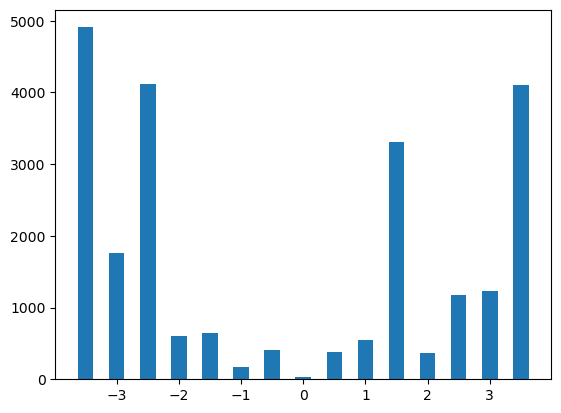

In [25]:
maker_stats = maker_df.groupby("edge")[["quantity"]].sum()
display(maker_stats.T)

plt.bar(maker_stats.index, maker_stats["quantity"], width=0.25)

### size distr of maker trades

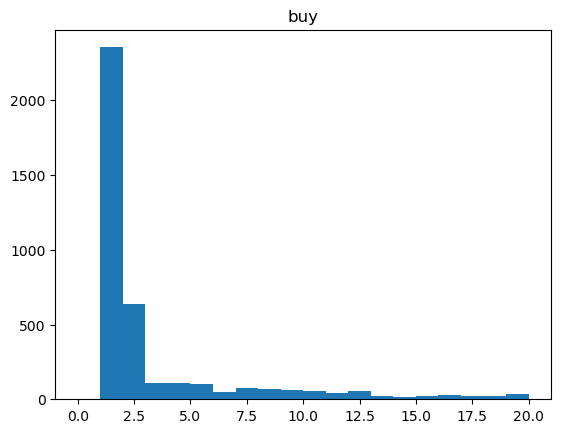

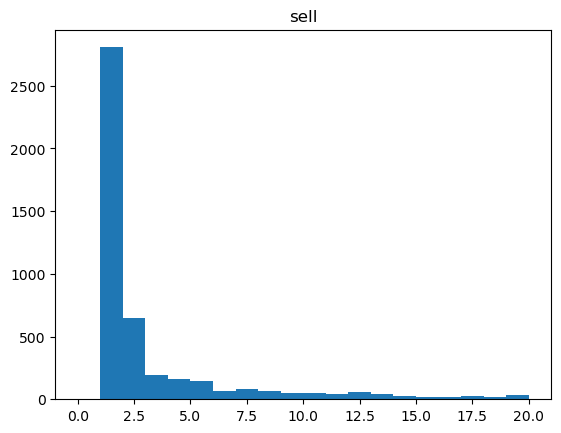

In [26]:
buy_maker_df = maker_df[maker_df["sell_edge"] > 0]
sell_maker_df = maker_df[maker_df["sell_edge"] < 0]

plt.hist(buy_maker_df["quantity"], bins=20, label="buy")
plt.title("buy")
plt.show()

plt.hist(sell_maker_df["quantity"], bins=20, label="sell")
plt.title("sell")
plt.show()

## Maker/taker stats summary

In [27]:
_factor = 1 / 30

print(f"Symbol: {_symbol}")

print("Total Maker Edge", maker_df["pnl"].sum())
print("Total Potential Taker Edge", taker_df["pnl"].sum())

print("Maker edge (scaled)", maker_df["pnl"].sum() * _factor)
print("Taker edge (scaled)", taker_df["pnl"].sum() * _factor)


Symbol: BANANAS
Total Maker Edge -7866.5
Total Potential Taker Edge 21106.0
Maker edge (scaled) -262.21666666666664
Taker edge (scaled) 703.5333333333333


In [28]:
num_turns = len(_day_range) * _max_time / _time_step
print("num turns", num_turns)
print("take ratio", len(taker_df) / num_turns)
print("make ratio", len(maker_df) / num_turns)



num turns 30000.0
take ratio 0.17543333333333333
make ratio 0.28196666666666664


### save data

In [29]:
# save quote_df
quote_df.to_csv(f"{_symbol}_quote_df.csv")

## func - get_rtns, scatter_noise

In [30]:
def get_rtns(quote_df, turn_offsets):
    
    data = []
    
    for diff in turn_offsets:
        shifted = quote_df["mid_price"].shift(-1 * diff)
        
        if diff < 0:
            data += [quote_df["mid_price"] - shifted]
        else:
            data += [shifted - quote_df["mid_price"]]
        
    rtn_df = pd.concat(data, axis=1)
    rtn_df.columns = [f"d_{diff}" for diff in turn_offsets]
    
    return rtn_df.dropna()
 
    

In [31]:
def scatter_noise(x, y, xnoise=0.1, ynoise=0.1, s=0.1, label=None):
    xp = x + np.random.normal(scale=xnoise, size=len(x))
    yp = y + np.random.normal(scale=ynoise, size=len(y))
    
    plt.scatter(
        xp, yp, 
        s=s, 
        label=label,
    )

In [32]:
maker_df

time   symbol   price  quantity  day  mid_price  sell_edge  edge  \
0         400  BANANAS  4899.0         9    0     4896.0        3.0   3.0   
1         500  BANANAS  4899.0         1    0     4896.0        3.0   3.0   
2        1400  BANANAS  4891.0         1    0     4893.5       -2.5  -2.5   
3        1500  BANANAS  4896.0         1    0     4893.5        2.5   2.5   
4        2200  BANANAS  4896.0        16    0     4892.5        3.5   3.5   
...       ...      ...     ...       ...  ...        ...        ...   ...   
8454  2998200  BANANAS  4793.0         1    2     4795.5       -2.5  -2.5   
8455  2998400  BANANAS  4793.0         2    2     4796.5       -3.5  -3.5   
8456  2999200  BANANAS  4792.0        18    2     4795.5       -3.5  -3.5   
8457  2999400  BANANAS  4798.0         1    2     4795.5        2.5   2.5   
8458  2999400  BANANAS  4798.0         1    2     4795.5        2.5   2.5   

       pnl  
0     27.0  
1      3.0  
2     -2.5  
3      2.5  
4     56.0  
...    ...  
8454  -2.5  
8455  -7.0  
8456 -63.0  
8457   2.5  
8458   2.5  

[8459 rows x 9 columns]

## large trade vs price change

In [33]:
# size
large_df = maker_df[maker_df["quantity"] > 30]

up_df = large_df[large_df["sell_edge"] > 0]
large_up_times = set(up_df["time"])

# rtns
rtn_df = get_rtns(quote_df, turn_offsets=[100])
rtn_df["time"] = price_df["time"]

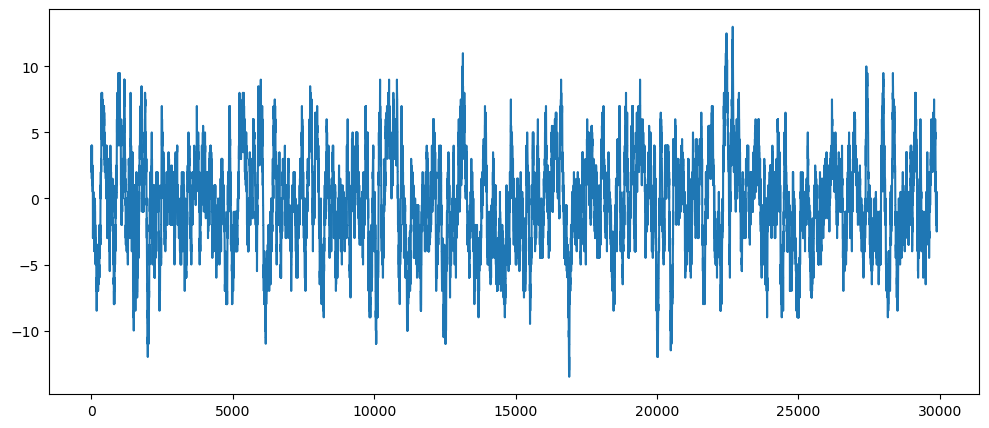

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(rtn_df["d_100"])


In [35]:
up_df

Empty DataFrame
Columns: [time, symbol, price, quantity, day, mid_price, sell_edge, edge, pnl]
Index: []

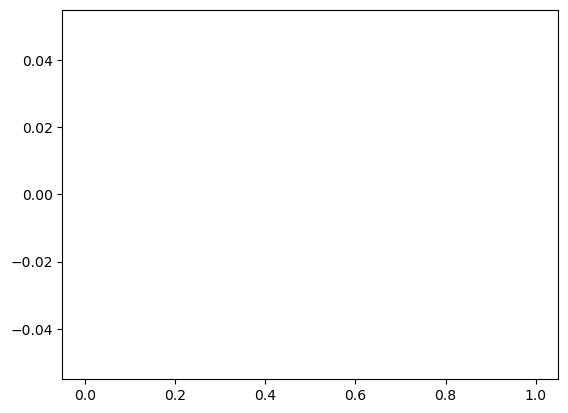

In [36]:
# 
plt.hist(rtn_df[rtn_df["time"].isin(large_up_times)]["d_100"], bins=100)
plt.show()

# Pairs analysis


## load data

In [37]:
pina_quote_df_path = 'PINA_COLADAS_quote_df.csv'
coco_quote_df_path = 'COCONUTS_quote_df.csv'
if not os.path.isfile(pina_quote_df_path) or not os.path.isfile(coco_quote_df_path):
    print("files dont exists")
    print(os.path.isfile(pc_quote_df_path))
    print(os.path.isfile(coco_quote_df_path))

# read orig quote_df's from files
pina_quote_df = pd.read_csv(pina_quote_df_path, index_col=0)
coco_quote_df = pd.read_csv(coco_quote_df_path, index_col=0)


In [38]:
# calculate pair_quote_df
pair_quote_df = pina_quote_df[["time"]].copy()
pair_quote_df["mid_diff"] = pina_quote_df["mid_price"] - 1 * coco_quote_df["mid_price"]
pair_quote_df["mid_ratio"] = pina_quote_df["mid_price"] / coco_quote_df["mid_price"]


## Calc returns

In [39]:
turn_offsets = [-500, -100, -50, -30, -10, -1, 1, 10, 30, 50, 100, 500]

# calc rtns
pina_rtn_df = get_rtns(pina_quote_df, turn_offsets=turn_offsets)
coco_rtn_df = get_rtns(coco_quote_df, turn_offsets=turn_offsets)

pair_rtn_df = pina_rtn_df - coco_rtn_df
pair_rtn_df = pair_rtn_df.add_prefix("rel_")

In [40]:
# validation

index = 500
print("cur time")
display(pina_quote_df.loc[[index, index + 500]])
display(coco_quote_df.loc[[index, index + 500]])

print("cur rtns")
display(pina_rtn_df.loc[[index, index + 500]])
display(coco_rtn_df.loc[[index, index + 500]])
display(pair_rtn_df.loc[[index, index + 500]])


cur time


buy_price  buy_size    time  sell_price  sell_size  mid_price  spread
500     15213.0      85.0   50000     15216.0       85.0    15214.5     3.0
1000    15233.0      97.0  100000     15236.0       97.0    15234.5     3.0

buy_price  buy_size    time  sell_price  sell_size  mid_price  spread
500      8092.0     182.0   50000      8095.0      182.0     8093.5     3.0
1000     8110.0     167.0  100000      8113.0      167.0     8111.5     3.0

cur rtns


d_-500  d_-100  d_-50  d_-30  d_-10  d_-1  d_1  d_10  d_30  d_50  d_100  \
500    -12.0    -2.5  -13.0  -14.0   -7.0   0.5  3.0   4.0   7.0  11.0   -4.0   
1000    20.0    -6.0   18.0   12.0    1.0   1.5 -0.5   4.0   4.0  -2.5  -12.0   

      d_500  
500    20.0  
1000  -76.0

d_-500  d_-100  d_-50  d_-30  d_-10  d_-1  d_1  d_10  d_30  d_50  d_100  \
500    -21.0    -1.0   -3.0   -2.0    0.0   1.0  1.0   0.0   3.0   2.0   -2.0   
1000    18.0    -8.0    4.0    4.0    2.0   0.0 -1.0   0.0  -2.5  -3.0   -4.0   

      d_500  
500    18.0  
1000  -14.0

rel_d_-500  rel_d_-100  rel_d_-50  rel_d_-30  rel_d_-10  rel_d_-1  \
500          9.0        -1.5      -10.0      -12.0       -7.0      -0.5   
1000         2.0         2.0       14.0        8.0       -1.0       1.5   

      rel_d_1  rel_d_10  rel_d_30  rel_d_50  rel_d_100  rel_d_500  
500       2.0       4.0       4.0       9.0       -2.0        2.0  
1000      0.5       4.0       6.5       0.5       -8.0      -62.0

## plot simple diff data

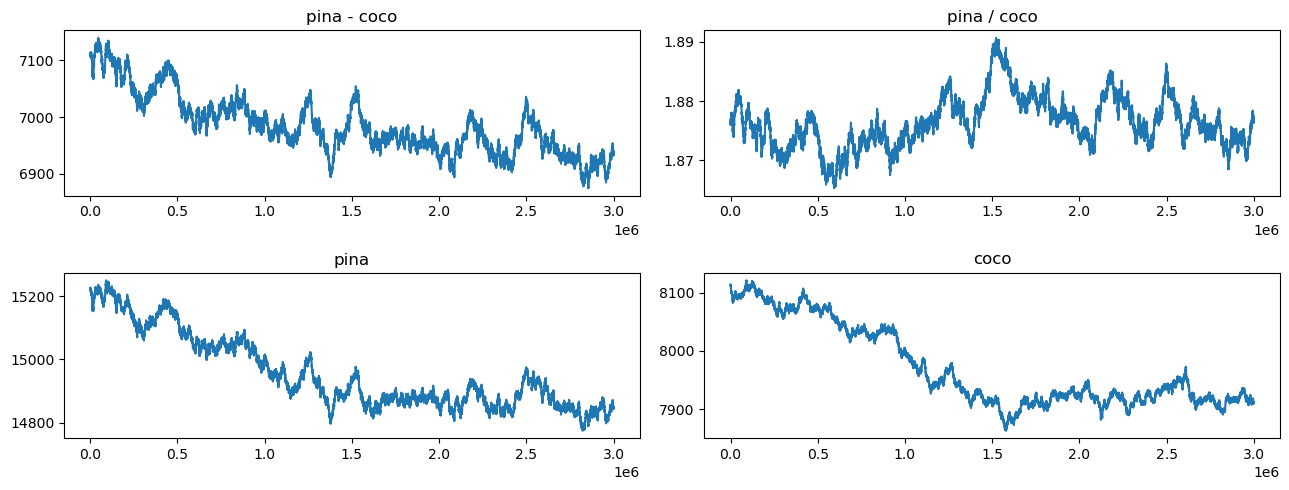

In [41]:
plt.figure(figsize=(13, 5))

plt.subplot(221)
plt.plot(pair_quote_df["time"], pair_quote_df["mid_diff"], label="pina - coco")
plt.title("pina - coco")

plt.subplot(222)
plt.plot(pair_quote_df["time"], pair_quote_df["mid_ratio"], label="pina / coco")
plt.title("pina / coco")

plt.subplot(223)
plt.plot(pina_quote_df["time"], pina_quote_df["mid_price"], label="pina")
plt.title("pina")

plt.subplot(224)
plt.plot(coco_quote_df["time"], coco_quote_df["mid_price"], label="coco")
plt.title("coco")

plt.tight_layout()
plt.show()


## pina: d_-1 vs d_1

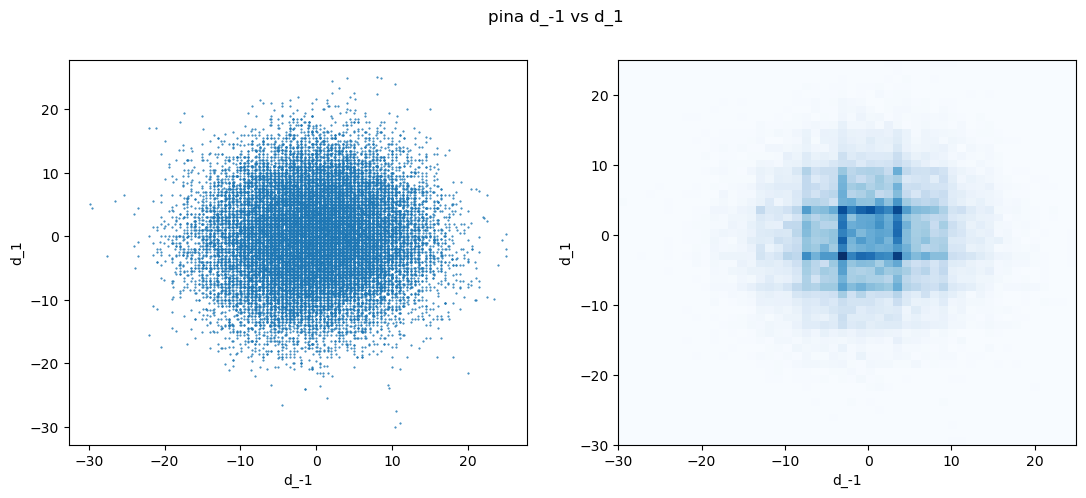

In [42]:
# histogram of d_-1 vs d_1
x = pina_rtn_df["d_-10"]
y = pina_rtn_df["d_10"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.suptitle("pina d_-1 vs d_1")
plt.show()


## coco: d_-1 vs d_1

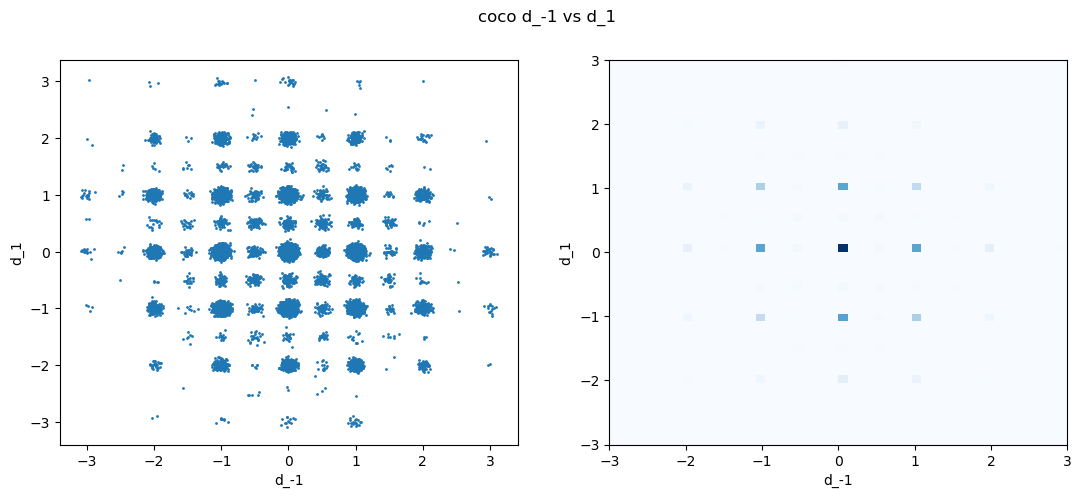

In [43]:
# histogram of d_-1 vs d_1

# lb = 2000
# lb_offset = 200
# ub = lb + lb_offset

lb, ub = 0, -1

df = coco_rtn_df
df = df.iloc[lb:ub]

x = df["d_-1"]
y = df["d_1"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=1)
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.suptitle("coco d_-1 vs d_1")
plt.show()


## pair: pina d_1 vs coco d_1

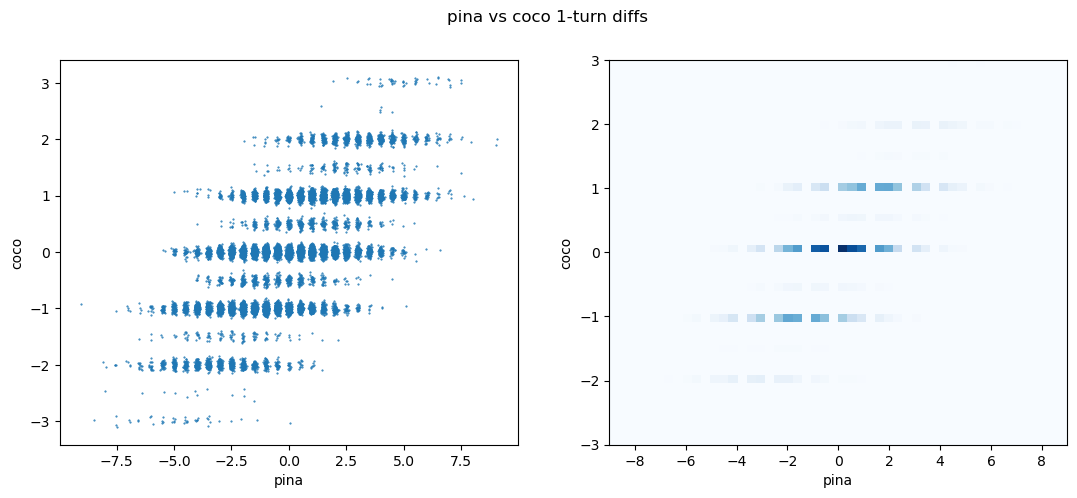

In [44]:
## plot pairs data

x = pina_rtn_df["d_1"]
y = coco_rtn_df["d_1"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("pina")
plt.ylabel("coco")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("pina")
plt.ylabel("coco")

plt.suptitle("pina vs coco 1-turn diffs")
plt.show()


## pair: predict pina -> coco

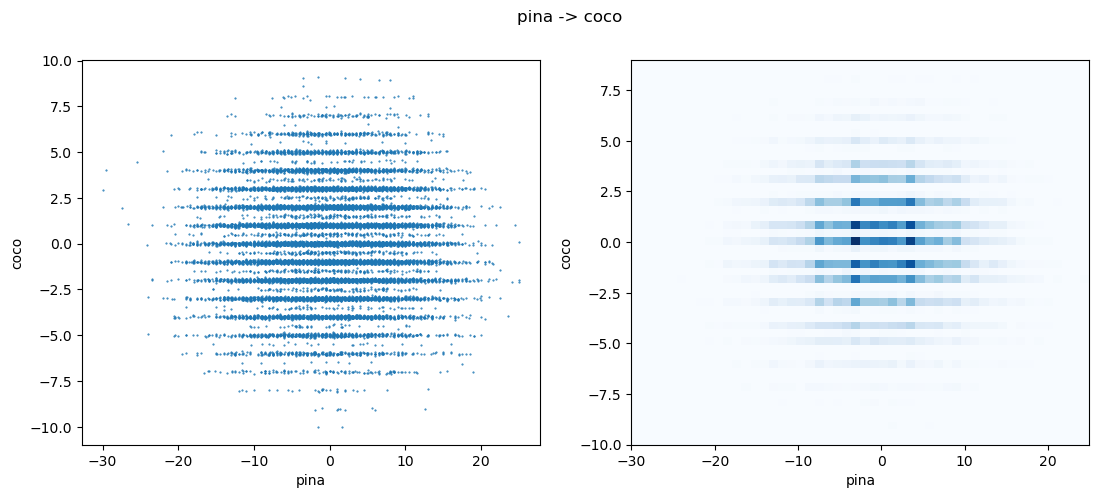

In [45]:
## plot pairs data

x = pina_rtn_df["d_-10"]
y = coco_rtn_df["d_10"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("pina")
plt.ylabel("coco")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("pina")
plt.ylabel("coco")

plt.suptitle("pina -> coco")
plt.show()


## pair: predict pina -> coco

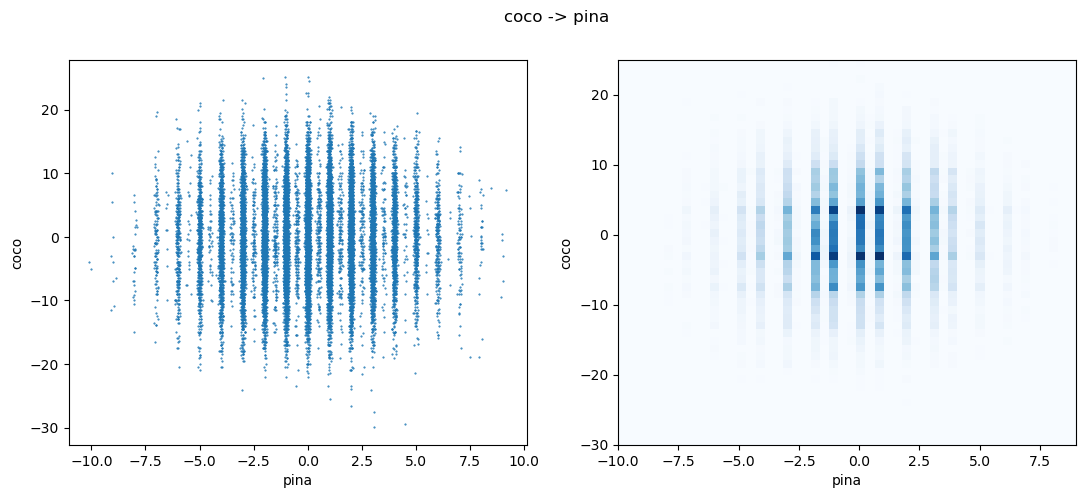

In [46]:
## plot pairs data

x = coco_rtn_df["d_-10"]
y = pina_rtn_df["d_10"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("pina")
plt.ylabel("coco")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("pina")
plt.ylabel("coco")

plt.suptitle("coco -> pina")
plt.show()


## pair trading: return to mean

In [47]:
# fit initial predictor
# X is predicting y

# X = coco_rtn_df[["d_100"]]
# y = pina_rtn_df[["d_100"]]

X = pina_rtn_df[["d_100"]]
y = coco_rtn_df[["d_100"]]

reg = LinearRegression().fit(X, y)

r2 = reg.score(X, y)
print("r2", r2)

print("weight", reg.coef_)
print("bias", reg.intercept_)


r2 0.5548542528304601
weight [[0.2868271]]
bias [-0.20630685]


In [48]:
# use previous error of predictor, to predict future error of predictor
### e.g.

ypred = reg.predict(X)

pred_df = pd.DataFrame(ypred, columns=y.columns.str.replace("d", "pred"), index=y.index)

for col in y.columns:
    offset = col.replace("d_", "")
    
    orig_col = "d_" + offset
    pred_col = "pred_" + offset
    error_col = "error_" + offset
    prev_error_col = "prev_error_" + offset
    
    # create pred_df with 
    pred_df[orig_col] = y[orig_col]
    pred_df[error_col] = pred_df[orig_col] - pred_df[pred_col]

    # get previous turns error
    pred_df[prev_error_col] = pred_df[error_col].shift(-1 * -100)
    
pred_df = pred_df.dropna()

# add time col
pred_df["time"] = pina_quote_df["time"]


In [49]:
def show_preds(
        chunk_size,
        chunk_index_start=0,
        num_shown=2,
        ):
    
    xcol = "prev_error_100"
    ycol = "error_100"
    
#     num_chunks = np.ceil(len(pred_df) / chunk_size).astype(int)

    for i in range(num_shown):
        
        chunk_index = chunk_index_start + i
        
        lb = chunk_size * chunk_index
        ub = min(lb + chunk_size, len(pred_df))
        df = pred_df.iloc[lb:ub]
        
        
        # calculate the time lb/ubs
        time_lb = df.iloc[0]["time"]
        time_ub = df.iloc[-1]["time"]
        
        print(lb, ub, time_lb, time_ub)

        scatter_noise(df[xcol], df[ycol], s=1, label=f"{time_lb} - {time_ub}")
        
    xmin = pred_df[xcol].min()
    xmax = pred_df[xcol].max()
    ymin = pred_df[ycol].min()
    ymax = pred_df[ycol].max()
        
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    
    plt.title(f"prev_error vs error - chunk_size={chunk_size}")
    
    plt.show()
    


In [50]:
interact(
    show_preds,
    chunk_size=200,
    chunk_index_start=(0, 1000, 1),
    num_shown=(1, 100, 1),
)

interactive(children=(IntSlider(value=200, description='chunk_size', max=600, min=-200), IntSlider(value=0, de…

<function __main__.show_preds(chunk_size, chunk_index_start=0, num_shown=2)>

In [51]:
X, y = pred_df[["prev_error_100"]], pred_df["error_100"]

reg = LinearRegression().fit(X, y)

print("r2", reg.score(X, y))


r2 0.0006079777905853012


## relative value

count      mean       std       min       25%       50%  \
mid_ratio  10000.0  1.873223  0.003094  1.865331  1.871038  1.873217   

                75%      max  
mid_ratio  1.875348  1.88191

Text(0.5, 1.0, 'mid ratio hist')

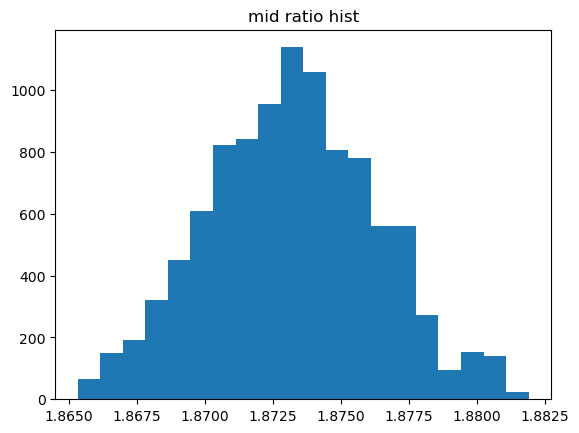

In [52]:
df = pair_quote_df.iloc[:10000]

# show stats on mid ratio
display(df[["mid_ratio"]].describe().T)

plt.hist(df["mid_ratio"], bins=20)
plt.title("mid ratio hist")

In [53]:
# calculate mids
mid_df = coco_quote_df.merge(pina_quote_df, on=["time"], suffixes=("_coco", "_pina"))
mid_df = mid_df.rename({"mid_price_coco": "coco_price", "mid_price_pina": "pina_price"}, axis=1)
mid_df = mid_df[["coco_price", "pina_price", "time"]]

In [54]:
# fit a linear model to prices
x = mid_df["coco_price"]
y = mid_df["pina_price"]
model = np.poly1d(np.polyfit(x, y, deg=1))
print("m, b", model.coef.astype(float))

model1 = np.poly1d(np.polyfit(x.iloc[:10000], y.iloc[:10000], deg=1))
model2 = np.poly1d(np.polyfit(x.iloc[10000:20000], y.iloc[10000:20000], deg=1))
model3 = np.poly1d(np.polyfit(x.iloc[20000:], y.iloc[20000:], deg=1))


m, b [1.62895288e+00 1.97189365e+03]


In [55]:
model1

poly1d([ 2.15897191e+00, -2.30388310e+03])

In [56]:
model2

poly1d([1.25941536e+00, 4.91460631e+03])

In [57]:
model3

poly1d([   1.95716416, -638.66358574])

In [58]:
# get rv (old stuff)
pair_quote_df["ratio_ma"] = pair_quote_df["mid_ratio"].ewm(span=21).mean()
pair_quote_df["ratio_diff"] = pair_quote_df["mid_ratio"] - pair_quote_df["ratio_ma"]

# predict pina price
pair_quote_df["pina_pred"] = model(mid_df["coco_price"])
pair_quote_df["pina_error"] = mid_df["pina_price"] - pair_quote_df["pina_pred"]


### linear model, coco to pina price

In [59]:
pair_quote_df.to_csv("pair_data.csv")

In [60]:
pair_quote_df[["pina_error"]].describe([0.1, 0.25, 0.5, 0.75, 0.9]).T


count          mean        std        min        10%        25%  \
pina_error  30000.0 -4.927278e-12  29.443716 -75.870169 -36.326489 -21.499122   

                 50%        75%        90%         max  
pina_error -2.485065  18.903548  38.822564  100.985066

(array([  15.,   19.,   11.,   74.,  112.,  178.,  268.,  375.,  435.,
         552.,  787.,  919.,  967., 1095., 1191., 1360., 1324., 1173.,
        1319., 1551., 1676., 1465., 1362., 1235., 1101., 1044., 1128.,
         958.,  832.,  914.,  728.,  604.,  476.,  397.,  362.,  381.,
         298.,  217.,  234.,  162.,  143.,  112.,   47.,   57.,  100.,
          92.,   52.,   56.,   32.,   10.]),
 array([-75.87016934, -72.33306462, -68.79595991, -65.2588552 ,
        -61.72175049, -58.18464577, -54.64754106, -51.11043635,
        -47.57333164, -44.03622693, -40.49912221, -36.9620175 ,
        -33.42491279, -29.88780808, -26.35070337, -22.81359865,
        -19.27649394, -15.73938923, -12.20228452,  -8.66517981,
         -5.12807509,  -1.59097038,   1.94613433,   5.48323904,
          9.02034375,  12.55744847,  16.09455318,  19.63165789,
         23.1687626 ,  26.70586731,  30.24297203,  33.78007674,
         37.31718145,  40.85428616,  44.39139087,  47.92849559,
         51.4656003 ,  5

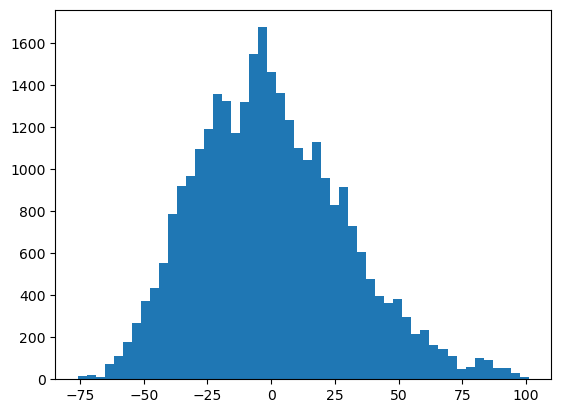

In [61]:
plt.hist(pair_quote_df["pina_error"], bins=50)

In [62]:
pair_quote_df[pair_quote_df["pina_error"] > 50]

time  mid_diff  mid_ratio  ratio_ma  ratio_diff     pina_pred  \
267      26700    7115.5   1.878619  1.878036    0.000583  15163.968546   
268      26800    7117.0   1.878805  1.878106    0.000699  15163.968546   
269      26900    7118.5   1.878881  1.878176    0.000705  15165.597499   
270      27000    7119.0   1.878835  1.878236    0.000598  15167.226452   
271      27100    7119.0   1.878943  1.878301    0.000643  15165.597499   
...        ...       ...        ...       ...         ...           ...   
25069  2506900    7019.0   1.883727  1.884070   -0.000343  14909.851897   
25070  2507000    7019.5   1.883790  1.884045   -0.000255  14909.851897   
25071  2507100    7020.0   1.883630  1.884007   -0.000377  14913.109803   
25074  2507400    7018.0   1.883490  1.883855   -0.000365  14911.480850   
25077  2507700    7018.0   1.883712  1.883772   -0.000060  14908.222944   

       pina_error  
267     50.031454  
268     51.531454  
269     52.402501  
270     52.273548  
271     52.902501  
...           ...  
25069   51.648103  
25070   52.148103  
25071   51.390197  
25074   50.019150  
25077   51.277056  

[1766 rows x 7 columns]

In [63]:
pair_rtn_df["rel_d_10"]

500      4.0
501      3.0
502      5.0
503      5.5
504      5.5
        ... 
29495    3.0
29496    2.5
29497    5.0
29498    4.0
29499    0.5
Name: rel_d_10, Length: 29000, dtype: float64

In [64]:
df = pair_quote_df.join(pair_rtn_df).dropna()

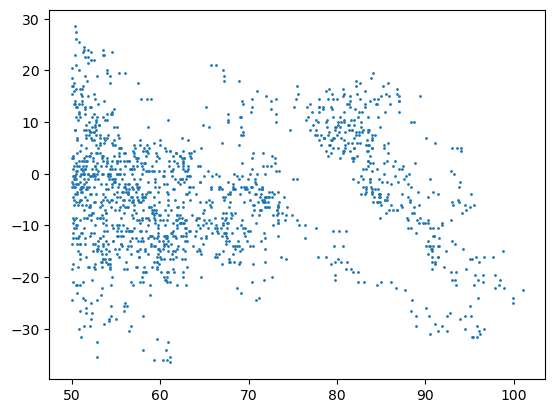

In [65]:
df = df[df["pina_error"] > 50]
plt.scatter(df["pina_error"], df["rel_d_50"], s=1)

In [66]:
x = df[["pina_error"]]
y = df["rel_d_50"]

reg = LinearRegression().fit(x, y)
reg.score(x, y)

0.0023304886378795464

### fit a sigmoid to pina_error

In [67]:
from scipy.optimize import curve_fit

def sigmoid(k, x):
    return 1 / (1 + np.exp(-k*x))

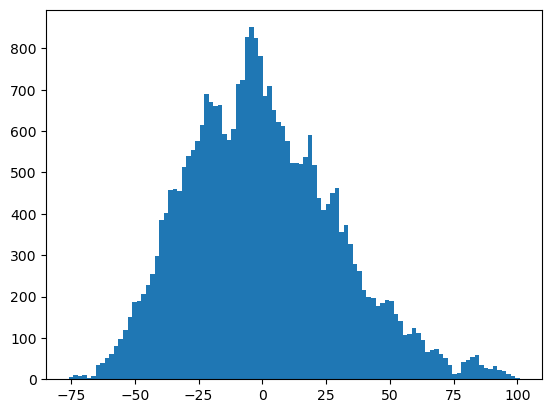

In [68]:
# plot distribution 
arr = np.sort(pair_quote_df["pina_error"])
cdf = np.arange(len(arr)) / len(arr)

counts = plt.hist(arr, bins=100)
plt.show()

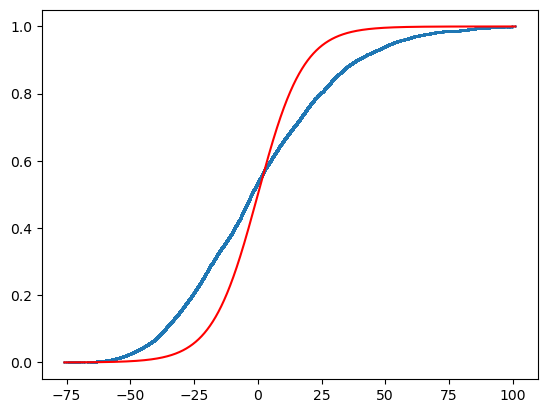

In [69]:
# fit a sigmoid
initial_guess = [1]
popt, pcov = curve_fit(sigmoid, arr, cdf, initial_guess, method='dogbox')

fit_fn = lambda x : sigmoid(popt[0]*2, x)
# fit_fn = lambda x : sigmoid(*popt, x)

# plot data + line
plt.scatter(arr, cdf, s=1)
plt.plot(arr, fit_fn(arr), color="red")

In [70]:
(fit_fn(5.13) - 0.5) / 0.5 * 300


83.7767302660491

### model as mean-reverting random walk?

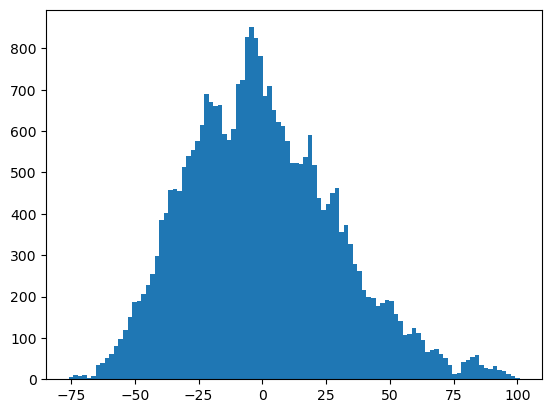

In [71]:
# get probabilities for 100 chunks
counts, bounds, _ = plt.hist(arr, bins=100)
# get means of bounds
bounds = [(bounds[i] + bounds[i+1])/2 for i in range(len(bounds) - 1)]
# get probabilities
probs = pd.DataFrame({"prob": counts / np.sum(counts), "x": bounds})


In [72]:
# shift up/down by 1
probs["up"] = probs["prob"].shift(-1)
probs["down"] = probs["prob"].shift(1)
probs = probs.dropna()

# get relative probability going up/down
probs["prob_total"] = probs["up"] + probs["down"]
probs["up"] = probs["up"] / probs["prob_total"]
probs["down"] = probs["down"] / probs["prob_total"]
probs["abs_x"] = abs(probs["x"])

In [73]:
probs["rtn"] = (probs["abs_x"] + 1) * probs["up"] * probs["prob"]

In [74]:
summ = probs.sort_values(by="rtn", ascending=False)
display(summ[summ["x"] >= 0].iloc[:10])
display(summ[summ["x"] <= 0].iloc[:10])

prob          x        up      down  prob_total      abs_x       rtn
58  0.015033  27.590143  0.522573  0.477427    0.029533  27.590143  0.224605
59  0.015433  29.358696  0.440447  0.559553    0.026867  29.358696  0.206365
61  0.012433  32.895801  0.478708  0.521292    0.022700  32.895801  0.201746
57  0.014100  25.821591  0.524419  0.475581    0.028667  25.821591  0.198327
53  0.019667  18.747382  0.491012  0.508988    0.035233  18.747382  0.190692
52  0.017933  16.978829  0.531532  0.468468    0.037000  16.978829  0.171377
60  0.011833  31.127248  0.446172  0.553828    0.027867  31.127248  0.169622
56  0.013633  24.053039  0.490719  0.509281    0.028733  24.053039  0.167608
62  0.010867  34.664353  0.427035  0.572965    0.021700  34.664353  0.165499
70  0.006367  48.812772  0.508021  0.491979    0.012467  48.812772  0.161115

prob          x        up      down  prob_total      abs_x       rtn
22  0.015267 -36.077741  0.534803  0.465197    0.028733  36.077741  0.302727
20  0.012867 -39.614846  0.573677  0.426323    0.023300  39.614846  0.299791
25  0.017067 -30.772084  0.543173  0.456827    0.033200  30.772084  0.294532
21  0.013367 -37.846294  0.542654  0.457346    0.028133  37.846294  0.281771
26  0.018033 -29.003532  0.519700  0.480300    0.035533  29.003532  0.281191
29  0.020500 -23.697875  0.545024  0.454976    0.042200  23.697875  0.275949
30  0.023000 -21.929322  0.521401  0.478599    0.042833  21.929322  0.274973
23  0.015367 -34.309189  0.498357  0.501643    0.030433  34.309189  0.270401
27  0.018467 -27.234980  0.515667  0.484333    0.037233  27.234980  0.268872
24  0.015167 -32.540637  0.526208  0.473792    0.032433  32.540637  0.267682

In [75]:
summ[summ["x"] >= 15]

prob          x        up      down  prob_total      abs_x       rtn
58  0.015033  27.590143  0.522573  0.477427    0.029533  27.590143  0.224605
59  0.015433  29.358696  0.440447  0.559553    0.026867  29.358696  0.206365
61  0.012433  32.895801  0.478708  0.521292    0.022700  32.895801  0.201746
57  0.014100  25.821591  0.524419  0.475581    0.028667  25.821591  0.198327
53  0.019667  18.747382  0.491012  0.508988    0.035233  18.747382  0.190692
52  0.017933  16.978829  0.531532  0.468468    0.037000  16.978829  0.171377
60  0.011833  31.127248  0.446172  0.553828    0.027867  31.127248  0.169622
56  0.013633  24.053039  0.490719  0.509281    0.028733  24.053039  0.167608
62  0.010867  34.664353  0.427035  0.572965    0.021700  34.664353  0.165499
70  0.006367  48.812772  0.508021  0.491979    0.012467  48.812772  0.161115
54  0.017300  20.515934  0.426628  0.573372    0.034300  20.515934  0.158802
63  0.009267  36.432905  0.444634  0.555366    0.019567  36.432905  0.154234
69  0.006133  47.044219  0.517615  0.482385    0.012300  47.044219  0.152526
55  0.014633  22.284486  0.440733  0.559267    0.030933  22.284486  0.150171
64  0.008700  38.201458  0.436105  0.563895    0.016433  38.201458  0.148735
71  0.006333  50.581324  0.452722  0.547278    0.011633  50.581324  0.147896
51  0.017333  15.210277  0.506591  0.493409    0.035400  15.210277  0.142341
67  0.006567  43.507115  0.470899  0.529101    0.012600  43.507115  0.137627
66  0.006667  41.738562  0.478155  0.521845    0.013733  41.738562  0.136238
68  0.005933  45.275667  0.482940  0.517060    0.012700  45.275667  0.132600
65  0.007167  39.970010  0.433839  0.566161    0.015367  39.970010  0.127383
76  0.004100  59.424086  0.502262  0.497738    0.007367  59.424086  0.124430
72  0.005267  52.349876  0.424242  0.575758    0.011000  52.349876  0.119202
75  0.003667  57.655534  0.534783  0.465217    0.007667  57.655534  0.115016
73  0.004667  54.118429  0.403774  0.596226    0.008833  54.118429  0.103858
77  0.003700  61.192638  0.438356  0.561644    0.007300  61.192638  0.100871
74  0.003567  55.886981  0.440000  0.560000    0.008333  55.886981  0.089275
89  0.001800  82.415267  0.557692  0.442308    0.003467  82.415267  0.083736
80  0.002333  66.498295  0.525180  0.474820    0.004633  66.498295  0.082714
87  0.001367  78.878162  0.741935  0.258065    0.002067  78.878162  0.080995
81  0.002433  68.266848  0.461538  0.538462    0.004333  68.266848  0.077792
78  0.003200  62.961191  0.372881  0.627119    0.005900  62.961191  0.076320
88  0.001533  80.646714  0.568421  0.431579    0.003167  80.646714  0.071162
90  0.001933  84.183819  0.386364  0.613636    0.002933  84.183819  0.063630
79  0.002200  64.729743  0.421687  0.578313    0.005533  64.729743  0.060978
82  0.002000  70.035400  0.416000  0.584000    0.004167  70.035400  0.059101
94  0.001100  91.258028  0.489362  0.510638    0.001567  91.258028  0.049662
83  0.001733  71.803952  0.368421  0.631579    0.003167  71.803952  0.046492
93  0.000800  89.489476  0.540984  0.459016    0.002033  89.489476  0.039163
92  0.000933  87.720924  0.413793  0.586207    0.001933  87.720924  0.034265
86  0.000533  77.109609  0.773585  0.226415    0.001767  77.109609  0.032226
91  0.001133  85.952371  0.325581  0.674419    0.002867  85.952371  0.032085
95  0.000767  93.026581  0.377358  0.622642    0.001767  93.026581  0.027203
96  0.000667  94.795133  0.342857  0.657143    0.001167  94.795133  0.021896
84  0.001167  73.572505  0.187500  0.812500    0.002133  73.572505  0.016313
97  0.000400  96.563685  0.259259  0.740741    0.000900  96.563685  0.010118
85  0.000400  75.341057  0.313725  0.686275    0.001700  75.341057  0.009580
98  0.000233  98.332238  0.200000  0.800000    0.000500  98.332238  0.004636

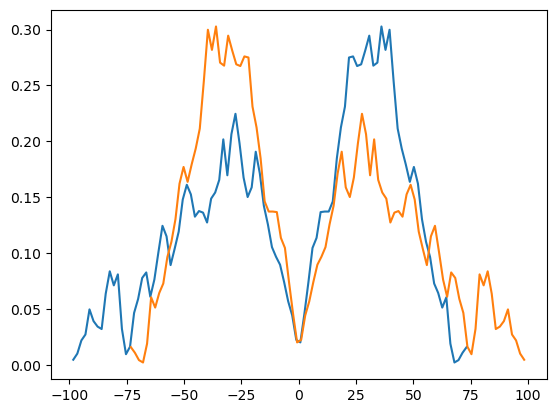

In [76]:
plt.plot(-probs["x"], probs["rtn"])
plt.plot(probs["x"], probs["rtn"])


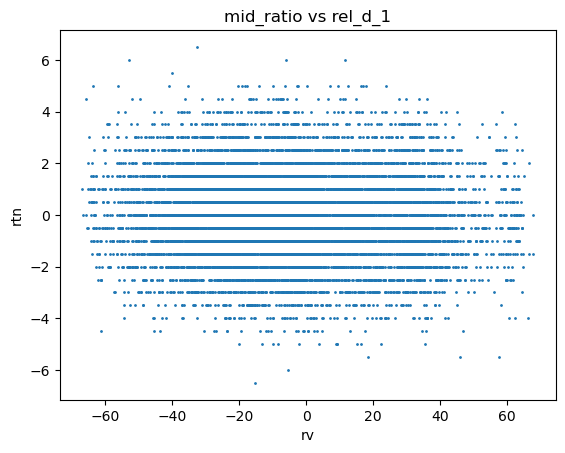

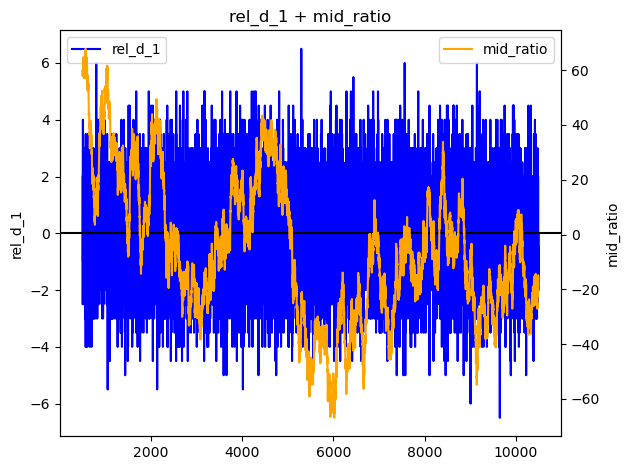

In [77]:
offset = 1
lb, lb_offset = 0, 10000
ub = lb + lb_offset

inds = pair_rtn_df.index.intersection(pair_quote_df.index)
inds = inds.to_series().iloc[lb:ub]

# mid ratio vs rel_d_offset
rvs = pair_quote_df.loc[inds]["pina_error"]
# rvs = pair_quote_df.loc[inds]["mid_ratio"] - pair_quote_df["mid_ratio"].mean()
# rvs = pair_quote_df.loc[inds]["ratio_diff"]
rtns = pair_rtn_df.loc[inds][f"rel_d_{offset}"]

plt.scatter(
    x=rvs,
    y=rtns,
    s=1,
)
plt.xlabel("rv")
plt.ylabel("rtn")
plt.title(f"mid_ratio vs rel_d_{offset}")
plt.show()

## first axis

fig, ax1 = plt.subplots()

ax1.plot(
    inds,
    rtns,
    label=f"rel_d_{offset}",
    color="blue",
)
ax1.set_ylabel(f"rel_d_{offset}")

## second axis

ax2 = ax1.twinx()
ax2.plot(
    inds,
    rvs,
    label="mid_ratio",
    color="orange",
)
ax2.set_ylabel("mid_ratio")

# draw hlines
ax1.axhline(y=0, color="black")

# draw labels
ax1.legend(loc=2)
ax2.legend(loc=1)

# overall plot features
plt.title(f"rel_d_{offset} + mid_ratio")

plt.tight_layout()
plt.show()

In [78]:
reg = LinearRegression().fit(rvs.to_frame(), rtns)
reg.score(rvs.to_frame(), rtns)

0.0009084006744675133

### func - plot_mids

In [233]:
def plot_mids(lb, offset, use_fade=False):
    # filter time
    ub = lb + offset
    
    df = mid_df.iloc[lb:ub]
    
    print("bounds", lb, ub)
    
    if ub > len(mid_df):
        print("end")
        



    x = df["coco_price"]
    y = df["pina_price"]

    xmin, xmax = mid_df["coco_price"].min(), mid_df["coco_price"].max()
    ymin, ymax = mid_df["pina_price"].min(), mid_df["pina_price"].max()

    if use_fade:
        alphas = np.arange(0, 1, 1 / offset) ** 2
    else:
        alphas = 1
    
    plt.scatter(x, y, alpha=alphas, s=1)
    plt.xlim(xmin - 10, xmax + 10)
    plt.ylim(ymin - 10, ymax + 10)
    
    # plot line of best fit
    
    ypred = model(mid_df["coco_price"])
    plt.plot(mid_df["coco_price"], ypred, color="black", alpha=1, linewidth=1, label="m_all")
    
    ypred = model1(mid_df["coco_price"])
    plt.plot(mid_df["coco_price"], ypred, color="blue", alpha=1, linewidth=1, label="m1")
    
    ypred = model2(mid_df["coco_price"])
    plt.plot(mid_df["coco_price"], ypred, color="purple", alpha=1, linewidth=1, label="m2")
    
    ypred = model3(mid_df["coco_price"])
    plt.plot(mid_df["coco_price"], ypred, color="red", alpha=1, linewidth=1, label="m3")
    
    plt.plot(mid_df["coco_price"], mid_df["coco_price"] + 7000, color="green", label="simple add")
    plt.plot(mid_df["coco_price"], mid_df["coco_price"] * 1.88, color="orange", label="simple ratio")
    plt.plot(mid_df["coco_price"], mid_df["coco_price"] * 1.5 + 3000, pattern="--", color="purple", label="simple ratio")
    
    plt.legend()

bounds 0 30000


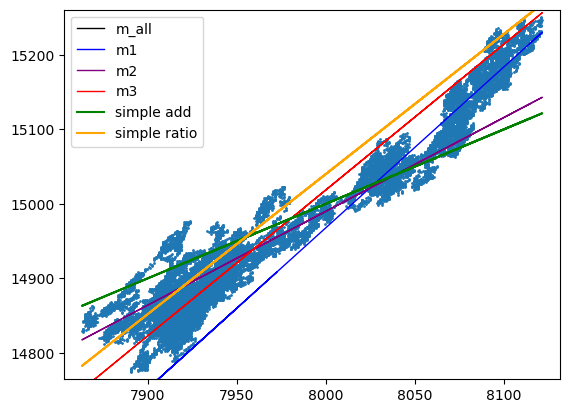

In [231]:
# plot all mids
plot_mids(0, 30000, use_fade=False)

### plot_mids - animated

In [81]:
# "animated" plot of mid prices of coco vs pina
interact(
    plot_mids,
    lb=(0, 30000, 100),
    offset=(0, 30000, 100),
    use_fade=True
)

interactive(children=(IntSlider(value=15000, description='lb', max=30000, step=100), IntSlider(value=15000, de…

<function __main__.plot_mids(lb, offset, use_fade=False)>

### multiple linregs

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/rzhan11/opt/miniconda3/envs/quant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, 

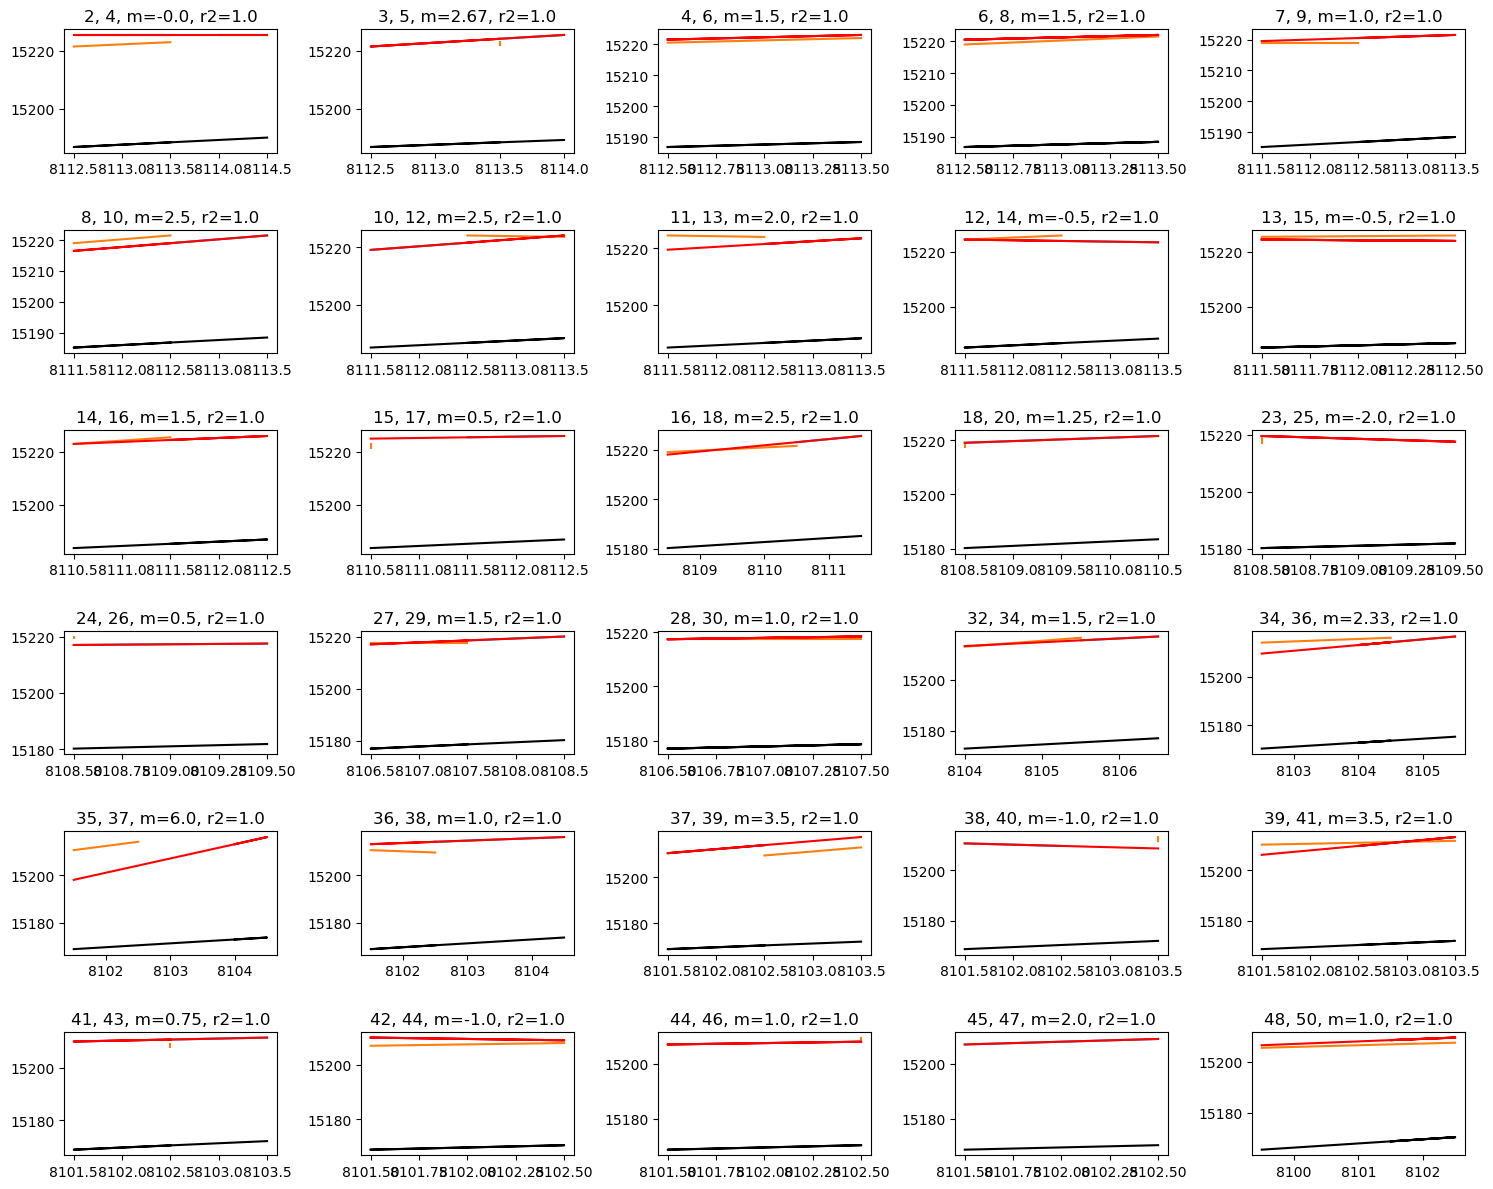

In [190]:
chunk_size = 2
# num_chunks = len(mid_df) // chunk_size

big_model = np.poly1d(np.polyfit(mid_df["coco_price"], mid_df["pina_price"], deg=1))

models = []

train_scores = []
test_scores = []
big_test_scores = []


plt.figure(figsize=(15, 12))

fig_ind = 1

# iterate for on less chunk
for ind in range(len(mid_df) - chunk_size):
    lb = ind
    ub = lb + chunk_size
    
    # get train/test data
    df = mid_df.iloc[lb:ub]
    df_test = mid_df.iloc[ub:ub+chunk_size]
    
    x, y = df["coco_price"], df["pina_price"]
    xtest, ytest = df_test["coco_price"], df_test["pina_price"]
        
    # fit model on training data
    model = np.poly1d(np.polyfit(x, y, deg=1))
    models += [model]
    
    # eval model on training data
    y_train_pred = model(x)
    train_scores += [r2_score(y, y_train_pred)]
    
    # eval model on testing data
    y_test_pred = model(xtest)
    test_scores += [r2_score(ytest, y_test_pred)]
    
    # eval bigmodel on testing data
    y_big_pred = big_model(xtest)
    big_test_scores += [r2_score(ytest, y_big_pred)]
    
    if train_scores[-1] > 0.8 and fig_ind <= 30:
#     if ind < 30:
        plt.subplot(6, 5, fig_ind)
        plt.title(f"{lb}, {ub}, m={round(model[1], 2)}, r2={round(train_scores[-1], 2)}")
#         plt.scatter(x, y, s=5)
        plt.plot(x, y)
#         plt.plot(xtest, ytest, s=5)
        plt.plot(xtest, ytest)
        plt.plot(list(x) + list(xtest), list(y_train_pred) + list(y_test_pred), color="red")
#         plt.plot(xtest, y_test_pred)
        plt.plot(list(x) + list(xtest), list(big_model(x)) + list(big_model(xtest)), color="black")
    
        fig_ind += 1
        
        
plt.tight_layout()
plt.show()

In [191]:
coefs = [m.coef for m in models]
model_df = pd.DataFrame(coefs, columns=["m", "b"])
model_df["r2_train"] = train_scores
model_df["r2_test"] = test_scores
model_df["r2_big_test"] = big_test_scores


In [199]:
mid_df

coco_price  pina_price     time
0          8114.5     15226.5        0
1          8114.5     15224.5      100
2          8114.5     15225.5      200
3          8114.0     15225.5      300
4          8112.5     15221.5      400
...           ...         ...      ...
29995      7909.5     14844.0  2999500
29996      7910.5     14845.5  2999600
29997      7911.5     14845.5  2999700
29998      7912.5     14849.5  2999800
29999      7911.5     14848.5  2999900

[30000 rows x 3 columns]

In [197]:
model_df

m             b  r2_train    r2_test  r2_big_test
0      9.381662e-01   7612.750000       0.0   0.000000     0.000000
1      9.381354e-01   7612.500000       0.0   0.553051  -314.292015
2     -3.309766e-13  15225.500000       1.0 -18.777778 -2134.881307
3      2.666667e+00  -6411.833333       1.0 -11.111111 -4650.465427
4      1.500000e+00   3052.750000       1.0  -0.777778 -2013.417709
...             ...           ...       ...        ...          ...
29993  9.382308e-01   7421.875000       0.0  -2.977238  -261.919714
29994 -1.500000e+00  26708.250000       1.0   0.000000     0.000000
29995  1.500000e+00   2979.750000       1.0   0.593750   -39.476207
29996 -1.992820e-12  14845.500000       0.0 -49.000000  -498.367016
29997  4.000000e+00 -16800.500000       1.0        NaN          NaN

[29998 rows x 5 columns]

In [192]:
model_df

m             b  r2_train    r2_test  r2_big_test
0      9.381662e-01   7612.750000       0.0   0.000000     0.000000
1      9.381354e-01   7612.500000       0.0   0.553051  -314.292015
2     -3.309766e-13  15225.500000       1.0 -18.777778 -2134.881307
3      2.666667e+00  -6411.833333       1.0 -11.111111 -4650.465427
4      1.500000e+00   3052.750000       1.0  -0.777778 -2013.417709
...             ...           ...       ...        ...          ...
29993  9.382308e-01   7421.875000       0.0  -2.977238  -261.919714
29994 -1.500000e+00  26708.250000       1.0   0.000000     0.000000
29995  1.500000e+00   2979.750000       1.0   0.593750   -39.476207
29996 -1.992820e-12  14845.500000       0.0 -49.000000  -498.367016
29997  4.000000e+00 -16800.500000       1.0        NaN          NaN

[29998 rows x 5 columns]

In [218]:
mid_df["coco_diff"] = mid_df["coco_price"].diff(1)
mid_df["pina_diff"] = mid_df["pina_price"].diff(1)
mid_df["diff_ratio"] = (mid_df["pina_diff"] / mid_df["coco_diff"]).replace([np.inf, -np.inf], np.nan)
mid_df

coco_price  pina_price     time  coco_diff  pina_diff  diff_ratio
0          8114.5     15226.5        0        NaN        NaN         NaN
1          8114.5     15224.5      100        0.0       -2.0         NaN
2          8114.5     15225.5      200        0.0        1.0         NaN
3          8114.0     15225.5      300       -0.5        0.0   -0.000000
4          8112.5     15221.5      400       -1.5       -4.0    2.666667
...           ...         ...      ...        ...        ...         ...
29995      7909.5     14844.0  2999500       -1.0        1.5   -1.500000
29996      7910.5     14845.5  2999600        1.0        1.5    1.500000
29997      7911.5     14845.5  2999700        1.0        0.0    0.000000
29998      7912.5     14849.5  2999800        1.0        4.0    4.000000
29999      7911.5     14848.5  2999900       -1.0       -1.0    1.000000

[30000 rows x 6 columns]

<AxesSubplot: >

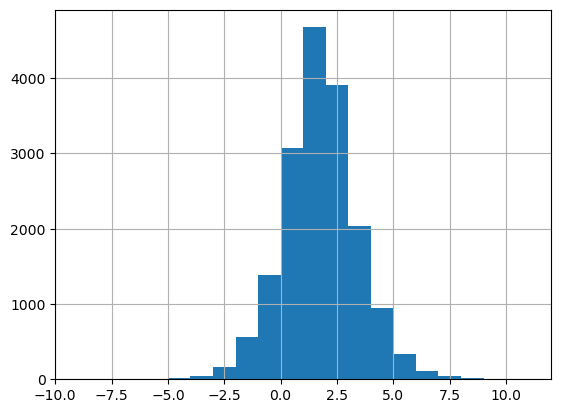

In [216]:
# mid_df.dropna()["diff_ratio"].hist(bins=20)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        7.000e+00, 0.000e+00, 1.300e+01, 0.000e+00, 4.300e+01, 9.200e+01,
        0.000e+00, 2.010e+02, 0.000e+00, 3.730e+02, 8.070e+02, 0.000e+00,
        1.116e+03, 0.000e+00, 1.844e+03, 2.251e+03, 0.000e+00, 3.153e+03,
        0.000e+00, 3.278e+03, 3.733e+03, 0.000e+00, 3.352e+03, 0.000e+00,
        3.061e+03, 2.282e+03, 0.000e+00, 1.793e+03, 0.000e+00, 1.054e+03,
        7.560e+02, 0.000e+00, 3.870e+02, 0.000e+00, 2.310e+02, 8.900e+01,
        0.000e+00, 5.200e+01, 0.000e+00, 1.400e+01, 1.000e+01, 0.000e+00,
        2.000e+00, 3.000e+00]),
 array([-8. , -7.7, -7.4, -7.1, -6.8, -6.5, -6.2, -5.9, -5.6, -5.3, -5. ,
        -4.7, -4.4, -4.1, -3.8, -3.5, -3.2, -2.9, -2.6, -2.3, -2. , -1.7,
        -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ,  1.3,  1.6,
         1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ,  4.3,  4.6,  4.9,
         5.2,  5.5,  5.8,  6.1,  6.4,  6.7,  7. ]),
 <BarContainer object of 50 

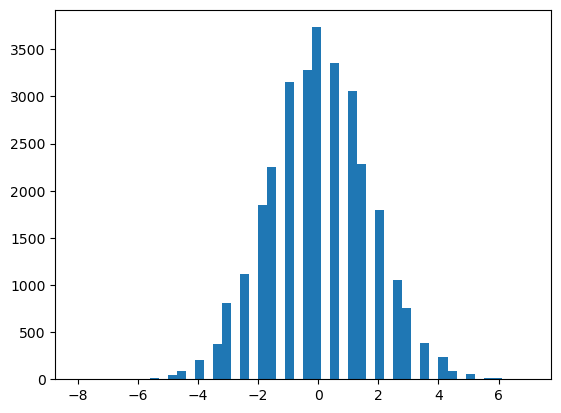

In [228]:
plt.hist(mid_df["pina_diff"] - mid_df["coco_diff"], bins=50)

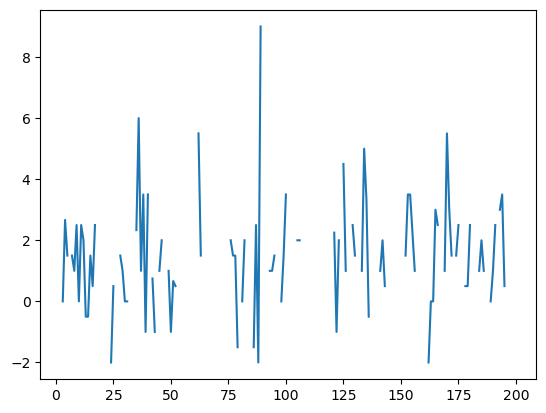

In [221]:
plt.plot(mid_df["diff_ratio"].iloc[:200])

m/b (-100, 1) [-7969.64425206 14954.69133894] 0.9999074477183045
num 29998


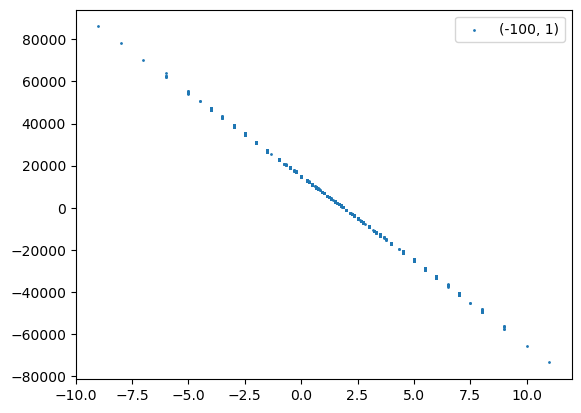

In [193]:
r2_limits = [-100, 1]

for i in range(len(r2_limits) - 1):
    lb, ub = r2_limits[i], r2_limits[i + 1]
    good_models = model_df[(lb < model_df["r2_train"]) & (model_df["r2_train"] <= ub)]

    if len(good_models) == 0:
        print(lb, ub, "no good models")
        continue
        
    plt.scatter(good_models["m"], good_models["b"], label=f"{lb, ub}", s=1)

    model = np.poly1d(np.polyfit(good_models["m"], good_models["b"], deg=1))
    print("m/b", (lb, ub), model.coef, r2_score(good_models["b"], model(good_models["m"])))
    print("num", len(good_models))
    
plt.legend()

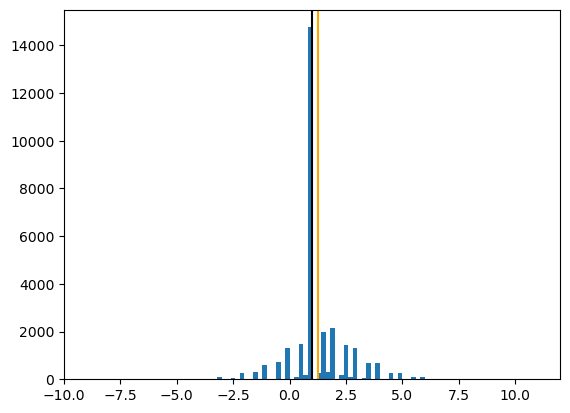

In [194]:
counts, bounds, _ = plt.hist(model_df["m"], bins=100)
plt.axvline(x=1.26, color="orange")
plt.axvline(x=1, color="black")
bounds = np.round(bounds, 2)

In [195]:
model_df["m"].mean()

1.2672380955157854

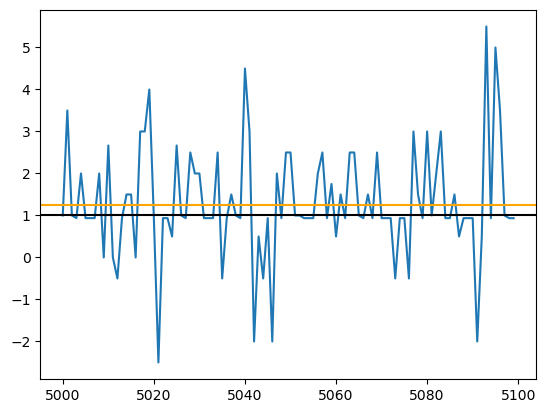

In [200]:
plt.plot(model_df.iloc[5000:5100]["m"])
plt.axhline(y=1.26, color="orange")
plt.axhline(y=1, color="black")


In [167]:
freq_df = pd.DataFrame({
    "value": zip(bounds[:-1], bounds[1:]),
    "freq": counts,
})

In [168]:
freq_df.sort_values(by="freq", ascending=False)

value    freq
49     (0.82, 1.0)  7452.0
55     (1.9, 2.08)  1057.0
52    (1.36, 1.54)  1008.0
47    (0.46, 0.64)   718.0
44    (-0.08, 0.1)   702.0
..             ...     ...
12  (-5.84, -5.66)     0.0
70     (4.6, 4.78)     0.0
71    (4.78, 4.96)     0.0
10   (-6.2, -6.02)     0.0
9    (-6.38, -6.2)     0.0

[100 rows x 2 columns]

In [ ]:
good_models["m"]

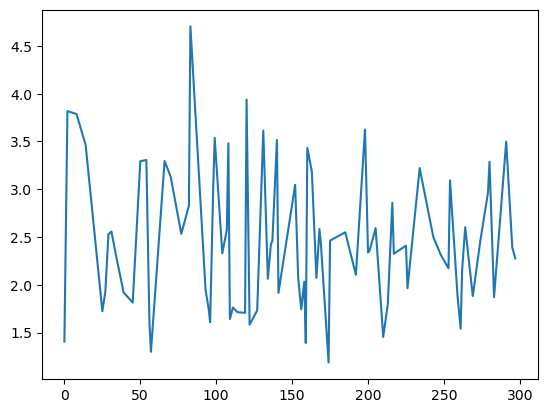

In [107]:
plt.plot(good_models["m"])

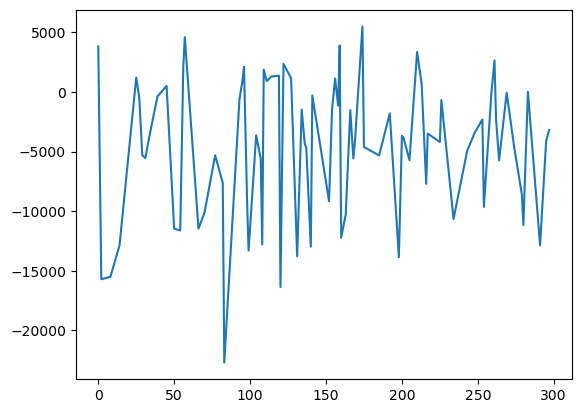

In [108]:
plt.plot(good_models["b"])

In [ ]:
g

<AxesSubplot: >

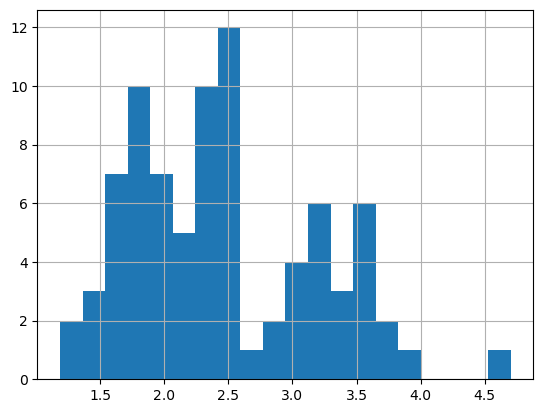

In [100]:
model_df[model_df["r2_train"] > 0.8]["m"].hist(bins=20)

<AxesSubplot: >

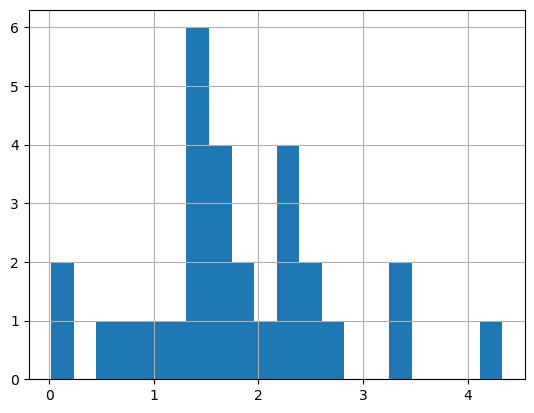

In [92]:
model_df["m"].hist(bins=20)

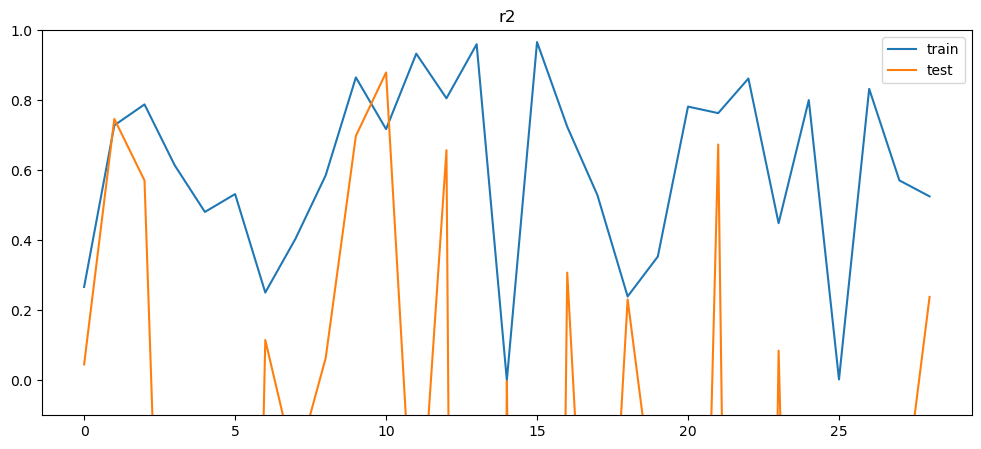

In [84]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_title("r2")
ax1.plot(model_df["r2_train"], label="train")
ax1.plot(model_df["r2_test"], label="test")
ax1.set_ylim(-0.1, 1)
# ax1.plot(model_df["r2_big_test"], label="big test")

ax1.legend()



In [85]:
model_df["m"].

m             b  r2_train    r2_test  r2_big_test
0   1.385056   3988.987356  0.266642   0.045407    -0.022357
1   2.574209  -5665.999049  0.728398   0.746774     0.591446
2   3.251215 -11131.744992  0.788199   0.570850     0.474715
3   2.614433  -5989.138091  0.614288  -1.998061    -1.789166
4   1.012677   6974.693798  0.480936  -7.248036    -1.744631
5   2.330633  -3725.421159  0.532007  -3.901072    -3.177082
6   0.730459   9166.783960  0.250688   0.115083    -0.823817
7   1.755155    941.615670  0.404370  -0.252169     0.580426
8   1.796713    624.557296  0.585537   0.063275    -0.010950
9   1.342428   4246.280683  0.865320   0.698160     0.424006
10  1.604643   2154.403299  0.717618   0.879386     0.907081
11  1.629325   1964.514772  0.933186  -0.620128    -0.299719
12  2.395907  -4100.970405  0.805649   0.657437     0.618810
13  3.308690 -11354.941675  0.960147 -10.811135    -2.556790
14  0.019199  14743.117753  0.000099  -0.002637    -1.734116
15  2.385350  -3930.237764  0.966370  -6.996112    -0.224931
16  1.211653   5285.636954  0.724418   0.307599    -1.710726
17  1.441134   3476.109972  0.528891  -1.285851    -0.428481
18  0.641156   9797.062442  0.239494   0.231104     0.278126
19  1.557667   2532.931148  0.353515  -0.438309    -0.826308
20  2.126347  -2001.937558  0.781990  -2.747926     0.180067
21  2.384376  -3980.226402  0.763294   0.673585     0.590731
22  2.190253  -2456.437754  0.862211  -5.731575    -1.711274
23  1.368610   4010.061545  0.448772   0.084636     0.488408
24  4.326898 -19417.937654  0.800613  -3.261228    -0.659091
25  0.156829  13680.144052  0.002377  -2.803579     0.697238
26  1.342066   4237.410444  0.832626  -1.475871    -2.986031
27  1.317419   4415.957915  0.571092  -0.446634    -3.214564
28  1.673938   1575.203103  0.525410   0.238249    -2.540185